<a href="https://colab.research.google.com/github/tiagocamillo/series-temporais/blob/main/Serie_Temporal_Tiago_(Exo).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Séries Temporais
Adaptado de: https://www.cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn.html

In [1]:
# Pandas
import pandas as pd

# Configuração do matplotlib
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Sklearn e Skforecast
from sklearn.ensemble import RandomForestRegressor

!pip install skforecast
from skforecast.ForecasterAutoreg import ForecasterAutoreg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 560.6/560.6 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.6 MB/s eta 0:00:00


In [2]:
# Carrega dados
url = 'https://raw.githubusercontent.com/tiagocamillo/series-temporais/main/Tomato.csv'
data = pd.read_csv(url, sep=',')
data.head(5)

,Date,Unit,Minimum,Maximum,Average,Market
0,2013-06-16,Kg,26,32,29.0,Tomato
1,2013-06-17,Kg,20,25,22.5,Tomato
2,2013-06-18,Kg,22,26,24.0,Tomato
3,2013-06-19,Kg,24,28,26.0,Tomato
4,2013-06-20,Kg,22,26,24.0,Tomato


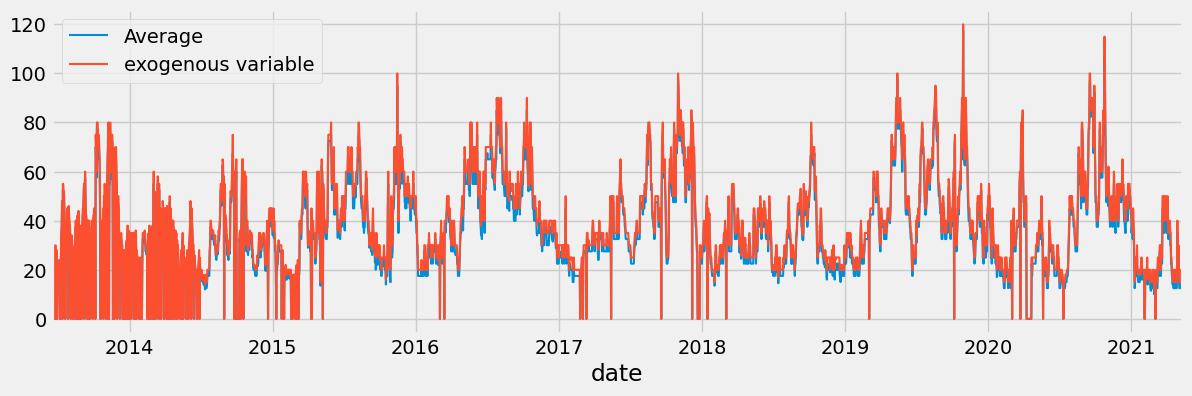

In [3]:
# Tratamento de dados
# Renomeia a coluna de data
data = data.rename(columns={'Date': 'date'})
# Converte data de string para datetime e transforma em índice
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
# Seto o índice
data = data.set_index('date')
# Defino a frequência (Mensal). Caso falte registro, cria um novo e preenche as demais colunas com 0.0
data = data.asfreq('D', fill_value=0.0)
# Ordena pela data
data = data.sort_index()

# Plota os dados
fig, ax = plt.subplots(figsize=(13, 4))
data['Average'].plot(ax=ax, label='Average')
data['Maximum'].plot(ax=ax, label='exogenous variable')
ax.legend();

In [4]:
print(f'Number of rows with missing values: {data.isnull().any(axis=1).mean()}')

Number of rows with missing values: 0.0


In [5]:
# Código para verificar se não existem "buracos" nos dados
(data.index == pd.date_range(start=data.index.min(),
                             end=data.index.max(),
                             freq=data.index.freq)).all()

True

In [6]:
# Em caso de buracos, podemos preencher os valores (Importante: verificar a frequência)
# data.asfreq(freq='30min', fill_value=np.nan)

Train dates : 2013-06-16 00:00:00 --- 2020-02-18 00:00:00  (n=2439)
Test dates  : 2020-02-19 00:00:00 --- 2021-05-13 00:00:00  (n=450)


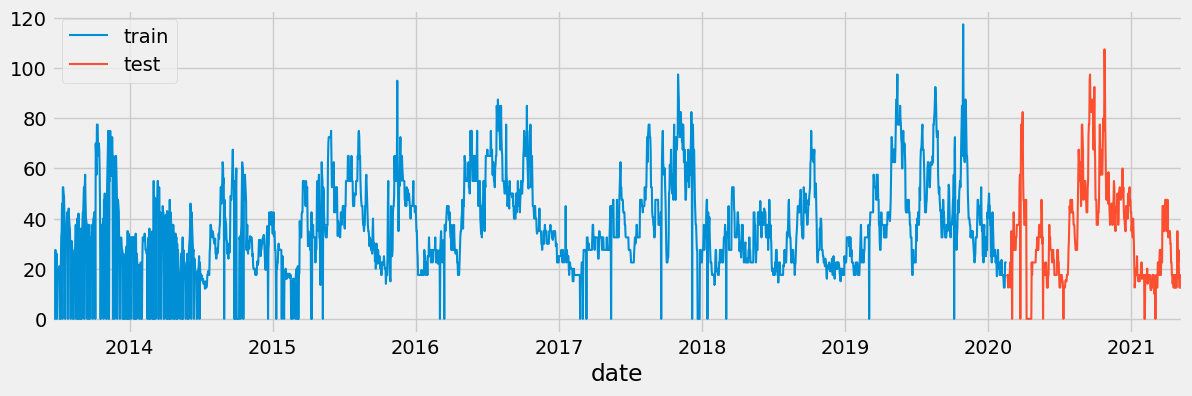

In [7]:
# Divide dados em treinamento e teste
# Para séries temporais, sempre utilizamos os dados mais recentes para teste
steps = 450
data_train = data[:-steps]
data_test  = data[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

# Plotando os dados
fig, ax=plt.subplots(figsize=(13, 4))
data_train['Average'].plot(ax=ax, label='train')
data_test['Average'].plot(ax=ax, label='test')
ax.legend();

In [8]:
# Configura e treina um RandomForestRegressor para série temporal
# Os parâmetros foram retirados do melhor modelo encontrado no material de origem
# Para conseguir os melhores parâmetros se faz necessário realizer hyperparameter tunning (verifique artigo original)
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(max_depth=10, n_estimators=50, random_state=123),
                lags      = 12
             )

forecaster.fit(y=data_train['Average'], exog=data_train['Maximum'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(max_depth=10, n_estimators=50, random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
Transformer for y: None 
Transformer for exog: None 
Window size: 12 
Weight function included: False 
Differentiation order: None 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.series.Series'> 
Exogenous variables names: Maximum 
Training range: [Timestamp('2013-06-16 00:00:00'), Timestamp('2020-02-18 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 10, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2024-06-07 01:37

In [9]:
# Faz predição no conjunto de teste
steps = 450
predictions = forecaster.predict(steps=steps, exog=data_test['Maximum'])
predictions.head(5)

2020-02-19    17.806406
2020-02-20    17.766823
2020-02-21    17.752077
2020-02-22    13.060000
2020-02-23    17.072860
Freq: D, Name: pred, dtype: float64

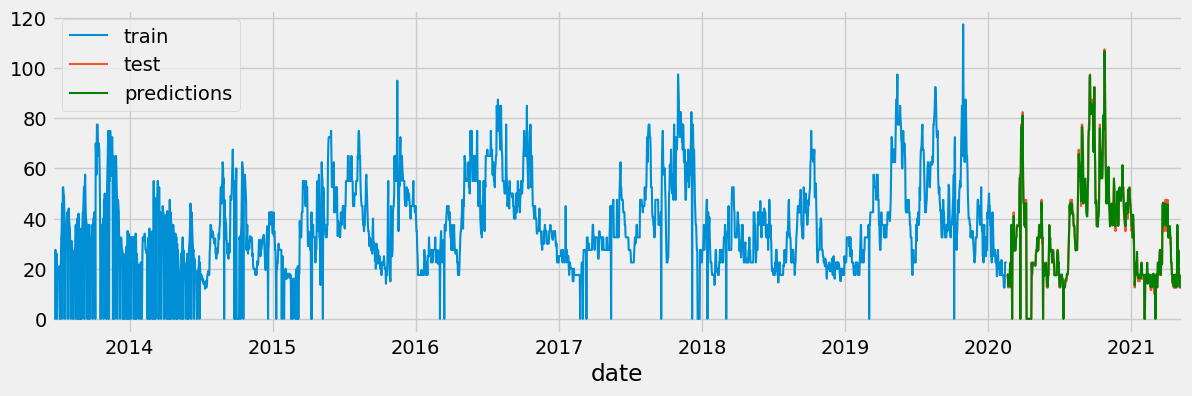

In [10]:
# Plota a predição, comparando com valores reais
fig, ax=plt.subplots(figsize=(13, 4))
data_train['Average'].plot(ax=ax, label='train')
data_test['Average'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions', color='green')
ax.legend();